In [1]:
%reload_ext sql
%config SqlMagic.autocommit=False
%config SqlMagic.autolimit=0
%config SqlMagic.autopandas=True
%config SqlMagic.displaylimit=200

In [2]:
%sql trino://localhost:9090/cuebiq/

'Connected: @cuebiq/'

In [3]:
# import geohash
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from datetime import datetime, timedelta

In [4]:
# SQL engine
from trino.dbapi import connect 
from sqlalchemy import create_engine
import pandas as pd
import time

class TrinoEngine():
    def __init__(self):
        conn = connect(
            host="localhost",
            port=9090,
            catalog="cuebiq"
        )
        self.cur = conn.cursor()
        self.engine = create_engine("trino://localhost:9090/cuebiq/")
    
    def execute_statement(self, query:str) -> list:
        """
        Create and drop statements.
        """
        self.cur.execute(query)
        return self.cur.fetchall()
    
    def read_sql(self, query:str) -> pd.DataFrame: 
        """
        Select and insert into operations.
        """
        return pd.read_sql(query, self.engine)

sql_engine = TrinoEngine()

In [5]:
schema_name = {'cda': 'cuebiq.paas_cda_pe_v3'}
pe_tj_table = f"{schema_name['cda']}.trajectory_uplevelled"

In [6]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [7]:
# for GH5
def fetch_and_save_aggregated_data(start_date, end_date, country_code, output_csv):
    """
    Fetches aggregated trajectory data from the SQL database and saves the output to a CSV file.

    Parameters:
    - start_date (int): The start date for filtering data (e.g., 20200701).
    - end_date (int): The end date for filtering data (e.g., 20201231).
    - country_code (str): The country code to filter the data (e.g., 'CO').
    - output_csv (str): The file path where the CSV should be saved.
    """

    query = f"""
    SELECT 
        local_date,
        start_geohash5,
        end_geohash5,
        grt,
        COUNT(cuebiq_id) AS trip_count,
        ROUND(AVG(duration_minutes), 6) AS m_duration_min,
        ROUND(APPROX_PERCENTILE(duration_minutes, 0.5), 6) AS mdn_duration_min,
        ROUND(STDDEV(duration_minutes), 6) AS sd_duration_min,
        ROUND(AVG(length_meters), 6) AS m_length_m,
        ROUND(APPROX_PERCENTILE(length_meters, 0.5), 6) AS mdn_length_m,
        ROUND(STDDEV(length_meters), 6) AS sd_length_m,
        ROUND(AVG(number_of_points), 6) AS m_points_no,
        ROUND(APPROX_PERCENTILE(number_of_points, 0.5), 6) AS mdn_points_no,
        ROUND(STDDEV(number_of_points), 6) AS sd_points_no
    FROM (
        SELECT 
            cuebiq_id,
            geohash_encode(start_lat, start_lng, 5) AS start_geohash5,
            geohash_encode(end_lat, end_lng, 5) AS end_geohash5,
            DATE(TRY(date_parse(substr(start_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s'))) AS local_date,
            extract(HOUR FROM date_parse(substr(start_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s'))/3  grt,
            duration_minutes,
            length_meters,
            number_of_points
        FROM cuebiq.paas_cda_pe_v3.trajectory_uplevelled
        WHERE 
            event_date BETWEEN {start_date} AND {end_date}
            AND end_country = '{country_code}' 
            AND start_country = '{country_code}'
    ) AS subquery
    GROUP BY 
        start_geohash5, end_geohash5, local_date, grt
    """

    # Execute the SQL query and read the result into a DataFrame
    df = sql_engine.read_sql(query)

    # Save the DataFrame to a CSV file
    df.to_csv(output_csv, index=False)

    print(f"Data successfully saved to {output_csv}")


In [8]:
# for GH3
def fetch_and_save_aggregated3_data(start_date, end_date, country_code, output_csv):
    """
    Fetches aggregated trajectory data from the SQL database and saves the output to a CSV file.

    Parameters:
    - start_date (int): The start date for filtering data (e.g., 20200701).
    - end_date (int): The end date for filtering data (e.g., 20201231).
    - country_code (str): The country code to filter the data (e.g., 'CO').
    - output_csv (str): The file path where the CSV should be saved.
    """

    query = f"""
    SELECT 
        local_date,
        start_geohash3,
        end_geohash3,
        grt,
        COUNT(cuebiq_id) AS trip_count,
        ROUND(AVG(duration_minutes), 6) AS m_duration_min,
        ROUND(APPROX_PERCENTILE(duration_minutes, 0.5), 6) AS mdn_duration_min,
        ROUND(STDDEV(duration_minutes), 6) AS sd_duration_min,
        ROUND(AVG(length_meters), 6) AS m_length_m,
        ROUND(APPROX_PERCENTILE(length_meters, 0.5), 6) AS mdn_length_m,
        ROUND(STDDEV(length_meters), 6) AS sd_length_m,
        ROUND(AVG(number_of_points), 6) AS m_points_no,
        ROUND(APPROX_PERCENTILE(number_of_points, 0.5), 6) AS mdn_points_no,
        ROUND(STDDEV(number_of_points), 6) AS sd_points_no
    FROM (
        SELECT 
            cuebiq_id,
            geohash_encode(start_lat, start_lng, 3) AS start_geohash3,
            geohash_encode(end_lat, end_lng, 3) AS end_geohash3,
            DATE(TRY(date_parse(substr(start_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s'))) AS local_date,
            extract(HOUR FROM date_parse(substr(start_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s'))/3  grt,
            duration_minutes,
            length_meters,
            number_of_points
        FROM cuebiq.paas_cda_pe_v3.trajectory_uplevelled
        WHERE 
            event_date BETWEEN {start_date} AND {end_date}
            AND end_country = '{country_code}' 
            AND start_country = '{country_code}'
    ) AS subquery
    GROUP BY 
        start_geohash3, end_geohash3, local_date, grt
    """

    # Execute the SQL query and read the result into a DataFrame
    df = sql_engine.read_sql(query)

    # Save the DataFrame to a CSV file
    df.to_csv(output_csv, index=False)

    print(f"Data successfully saved to {output_csv}")


In [32]:
fetch_and_save_aggregated_data(20200101, 20200131, 'IN', 
                               '/home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_1.csv')

Data successfully saved to /home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_1.csv


In [33]:
fetch_and_save_aggregated_data(20200201, 20200229, 'IN', 
                               '/home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_2.csv')

Data successfully saved to /home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_2.csv


In [34]:
fetch_and_save_aggregated_data(20200301, 20200331, 'IN', 
                               '/home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_3.csv')

Data successfully saved to /home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_3.csv


In [35]:
fetch_and_save_aggregated_data(20200401, 20200430, 'IN', 
                               '/home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_4.csv')

Data successfully saved to /home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_4.csv


In [36]:
fetch_and_save_aggregated_data(20200501, 20200531, 'IN', 
                               '/home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_5.csv')

Data successfully saved to /home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_5.csv


In [37]:
fetch_and_save_aggregated_data(20200601, 20200630, 'IN', 
                               '/home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_6.csv')

Data successfully saved to /home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_6.csv


In [38]:
fetch_and_save_aggregated_data(20200701, 20200731, 'IN', 
                               '/home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_7.csv')

Data successfully saved to /home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_7.csv


In [39]:
fetch_and_save_aggregated_data(20200801, 20200831, 'IN', 
                               '/home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_8.csv')

Data successfully saved to /home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_8.csv


In [40]:
fetch_and_save_aggregated_data(20200901, 20200930, 'IN', 
                               '/home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_9.csv')

Data successfully saved to /home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_9.csv


In [41]:
fetch_and_save_aggregated_data(20201001, 20201031, 'IN', 
                               '/home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_10.csv')

Data successfully saved to /home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_10.csv


In [42]:
fetch_and_save_aggregated_data(20201101, 20201130, 'IN', 
                               '/home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_11.csv')

Data successfully saved to /home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_11.csv


In [43]:
fetch_and_save_aggregated_data(20201201, 20201231, 'IN', 
                               '/home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_12.csv')

Data successfully saved to /home/jovyan/Data/2020OD/del_3h/od_in_agg5_3h_12.csv


In [32]:
fetch_and_save_aggregated3_data(20200831, 20200831, 'ID', 
                               '/home/jovyan/Data/2020OD/del_3h/od3_id_3h_8.csv')

Data successfully saved to /home/jovyan/Data/2020OD/del_3h/od3_id_3h_8.csv


In [13]:
fetch_and_save_aggregated_data(20190831, 20190831, 'IN', 
                               '/home/jovyan/Data/2020OD/del_3h/od5_in_3h_19831.csv')

Data successfully saved to /home/jovyan/Data/2020OD/del_3h/od5_in_3h_19831.csv


In [14]:
od2 = '/home/jovyan/Data/2020OD/del_3h/od5_in_3h_19831.csv'
df_od2 = pd.read_csv(od2)
df_od2

,local_date,start_geohash5,end_geohash5,grt,trip_count,m_duration_min,mdn_duration_min,sd_duration_min,m_length_m,mdn_length_m,sd_length_m,m_points_no,mdn_points_no,sd_points_no
0,2019-08-31,ttng4,ttng3,3,2,398.066667,638.916667,340.613336,36996.626351,64180.460806,38443.747364,17.00,27,14.142136
1,2019-08-31,tee9j,tee9j,7,1,45.983333,45.983333,NaN,989.637743,989.637743,NaN,8.00,8,NaN
2,2019-08-31,tg428,tg423,3,1,404.616667,404.616667,NaN,11105.086557,11105.086557,NaN,10.00,10,NaN
3,2019-08-31,ts1s1,ts1s1,2,4,66.750000,30.283333,93.158335,2315.881717,2244.789792,2080.204864,5.75,6,2.872281
4,2019-08-31,ttqp9,ttqp9,5,2,147.516667,178.400000,43.675629,2129.177539,2248.169700,168.280327,4.00,6,2.828427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108743,2019-08-31,ttn8s,ttndp,2,1,132.266667,132.266667,NaN,33595.723824,33595.723824,NaN,10.00,10,NaN
108744,2019-08-31,tu9ct,tud0b,4,1,49.750000,49.750000,NaN,17423.728779,17423.728779,NaN,4.00,4,NaN
108745,2019-08-31,tek96,tek91,4,1,38.200000,38.200000,NaN,5934.925667,5934.925667,NaN,4.00,4,NaN
108746,2019-08-31,ttngn,ttnfk,5,1,95.033333,95.033333,NaN,30873.172421,30873.172421,NaN,25.00,25,NaN


In [52]:
od8 = '/home/jovyan/Data/2020OD/del_3h/od5_id_3h_8.csv'
df_od8 = pd.read_csv(od8)
df_od8

,local_date,start_geohash5,end_geohash5,grt,trip_count,m_duration_min,mdn_duration_min,sd_duration_min,m_length_m,mdn_length_m,sd_length_m,m_points_no,mdn_points_no,sd_points_no
0,2020-08-31,qqggy,qqggy,3,5,53.446667,22.683333,83.795732,565.649849,630.896340,494.370832,3.2,4,1.095445
1,2020-08-31,qxw3d,qxw3d,5,1,13.216667,13.216667,NaN,93.409070,93.409070,NaN,2.0,2,NaN
2,2020-08-31,qqwv5,qqwug,3,1,36.866667,36.866667,NaN,3410.837598,3410.837598,NaN,2.0,2,NaN
3,2020-08-31,qqguf,qqgv5,2,1,181.483333,181.483333,NaN,10238.682344,10238.682344,NaN,10.0,10,NaN
4,2020-08-31,w0pkf,w0pm4,4,1,28.516667,28.516667,NaN,4368.770532,4368.770532,NaN,6.0,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14814,2020-08-31,qqu8f,qqu8c,2,1,52.533333,52.533333,NaN,6092.486971,6092.486971,NaN,6.0,6,NaN
14815,2020-08-31,qqu2w,qqu90,4,1,89.500000,89.500000,NaN,16303.243400,16303.243400,NaN,14.0,14,NaN
14816,2020-08-31,qqu8p,qqu8p,3,1,124.966667,124.966667,NaN,2807.937605,2807.937605,NaN,6.0,6,NaN
14817,2020-08-31,qqggz,qqggx,5,1,61.133333,61.133333,NaN,23914.873945,23914.873945,NaN,13.0,13,NaN


In [15]:
final_df = pd.concat([df_od2, df_od8], ignore_index=True)
# final_df = df_od2
final_df

,local_date,start_geohash5,end_geohash5,grt,trip_count,m_duration_min,mdn_duration_min,sd_duration_min,m_length_m,mdn_length_m,sd_length_m,m_points_no,mdn_points_no,sd_points_no
0,2019-08-31,ttng4,ttng3,3,2,398.066667,638.916667,340.613336,36996.626351,64180.460806,38443.747364,17.00,27,14.142136
1,2019-08-31,tee9j,tee9j,7,1,45.983333,45.983333,NaN,989.637743,989.637743,NaN,8.00,8,NaN
2,2019-08-31,tg428,tg423,3,1,404.616667,404.616667,NaN,11105.086557,11105.086557,NaN,10.00,10,NaN
3,2019-08-31,ts1s1,ts1s1,2,4,66.750000,30.283333,93.158335,2315.881717,2244.789792,2080.204864,5.75,6,2.872281
4,2019-08-31,ttqp9,ttqp9,5,2,147.516667,178.400000,43.675629,2129.177539,2248.169700,168.280327,4.00,6,2.828427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108743,2019-08-31,ttn8s,ttndp,2,1,132.266667,132.266667,NaN,33595.723824,33595.723824,NaN,10.00,10,NaN
108744,2019-08-31,tu9ct,tud0b,4,1,49.750000,49.750000,NaN,17423.728779,17423.728779,NaN,4.00,4,NaN
108745,2019-08-31,tek96,tek91,4,1,38.200000,38.200000,NaN,5934.925667,5934.925667,NaN,4.00,4,NaN
108746,2019-08-31,ttngn,ttnfk,5,1,95.033333,95.033333,NaN,30873.172421,30873.172421,NaN,25.00,25,NaN


In [16]:
final_df['local_date'] = pd.to_datetime(final_df['local_date']).dt.strftime('%Y%m%d')
time_intervals = {
    0: "00:00:00 - 03:00:00", 1: "03:00:00 - 06:00:00",
    2: "06:00:00 - 09:00:00", 3: "09:00:00 - 12:00:00",
    4: "12:00:00 - 15:00:00", 5: "15:00:00 - 18:00:00",
    6: "18:00:00 - 21:00:00", 7: "21:00:00 - 24:00:00"}
final_df['local_time'] = final_df.apply(lambda row: f"{row['local_date']} {time_intervals[row['grt']]}", axis=1).astype(str)
final_df = final_df.drop(['grt'], axis=1)

final_df

,local_date,start_geohash5,end_geohash5,trip_count,m_duration_min,mdn_duration_min,sd_duration_min,m_length_m,mdn_length_m,sd_length_m,m_points_no,mdn_points_no,sd_points_no,local_time
0,20190831,ttng4,ttng3,2,398.066667,638.916667,340.613336,36996.626351,64180.460806,38443.747364,17.00,27,14.142136,20190831 09:00:00 - 12:00:00
1,20190831,tee9j,tee9j,1,45.983333,45.983333,NaN,989.637743,989.637743,NaN,8.00,8,NaN,20190831 21:00:00 - 24:00:00
2,20190831,tg428,tg423,1,404.616667,404.616667,NaN,11105.086557,11105.086557,NaN,10.00,10,NaN,20190831 09:00:00 - 12:00:00
3,20190831,ts1s1,ts1s1,4,66.750000,30.283333,93.158335,2315.881717,2244.789792,2080.204864,5.75,6,2.872281,20190831 06:00:00 - 09:00:00
4,20190831,ttqp9,ttqp9,2,147.516667,178.400000,43.675629,2129.177539,2248.169700,168.280327,4.00,6,2.828427,20190831 15:00:00 - 18:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108743,20190831,ttn8s,ttndp,1,132.266667,132.266667,NaN,33595.723824,33595.723824,NaN,10.00,10,NaN,20190831 06:00:00 - 09:00:00
108744,20190831,tu9ct,tud0b,1,49.750000,49.750000,NaN,17423.728779,17423.728779,NaN,4.00,4,NaN,20190831 12:00:00 - 15:00:00
108745,20190831,tek96,tek91,1,38.200000,38.200000,NaN,5934.925667,5934.925667,NaN,4.00,4,NaN,20190831 12:00:00 - 15:00:00
108746,20190831,ttngn,ttnfk,1,95.033333,95.033333,NaN,30873.172421,30873.172421,NaN,25.00,25,NaN,20190831 15:00:00 - 18:00:00


In [17]:
final_df.to_csv('/home/jovyan/Data/2020OD/del_3h/od5_in_3h_19831.csv', index=False)

In [36]:
pd_file = '/home/jovyan/Data/2020OD/del_3h/od_mx_agg5_3h.csv'
df_od = pd.read_csv(pd_file)
df_od

,start_geohash5,end_geohash5,local_date,trip_count,m_duration_min,mdn_duration_min,sd_duration_min,m_length_m,mdn_length_m,sd_length_m,m_points_no,mdn_points_no,sd_points_no,local_time
0,9emgx,9emgx,20200101,5,178.186667,29.783333,308.801904,908.585005,1009.644583,502.969904,8.800000,8.0,5.069517,20200101 00:00:00 - 03:00:00
1,9emmx,9emmx,20200101,1,603.883333,603.883333,NaN,6535.087112,6535.087112,NaN,4.000000,4.0,NaN,20200101 00:00:00 - 03:00:00
2,9emmx,9emmz,20200101,1,437.416667,437.416667,NaN,3205.701242,3205.701242,NaN,2.000000,2.0,NaN,20200101 00:00:00 - 03:00:00
3,9emmx,9emt3,20200101,1,704.666667,704.666667,NaN,13706.785497,13706.785497,NaN,14.000000,14.0,NaN,20200101 00:00:00 - 03:00:00
4,9emmx,9eqjx,20200101,1,1151.833333,1151.833333,NaN,335261.406959,335261.406959,NaN,7.000000,7.0,NaN,20200101 00:00:00 - 03:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8344165,d5f22,d5f22,20200508,6,48.530556,41.141667,39.301204,1974.524763,1989.649241,1384.792950,5.333333,4.5,1.966384,20200508 06:00:00 - 09:00:00
8344166,d5f22,d5f28,20200508,2,59.275000,59.275000,38.478394,3819.111745,3819.111745,3456.421386,6.000000,6.0,4.242641,20200508 06:00:00 - 09:00:00
8344167,d5f28,d5f0x,20200508,1,65.066667,65.066667,NaN,4428.151562,4428.151562,NaN,17.000000,17.0,NaN,20200508 06:00:00 - 09:00:00
8344168,d5f28,d5f22,20200508,3,53.611111,57.016667,39.784469,3682.793434,3806.881022,2411.528414,3.666667,3.0,2.081666,20200508 06:00:00 - 09:00:00


In [37]:
df_od[df_od['local_date'] == 20200229]['trip_count'].sum()

290025

In [38]:
df_od[df_od['local_date'] == 20200228]['trip_count'].sum()

329552

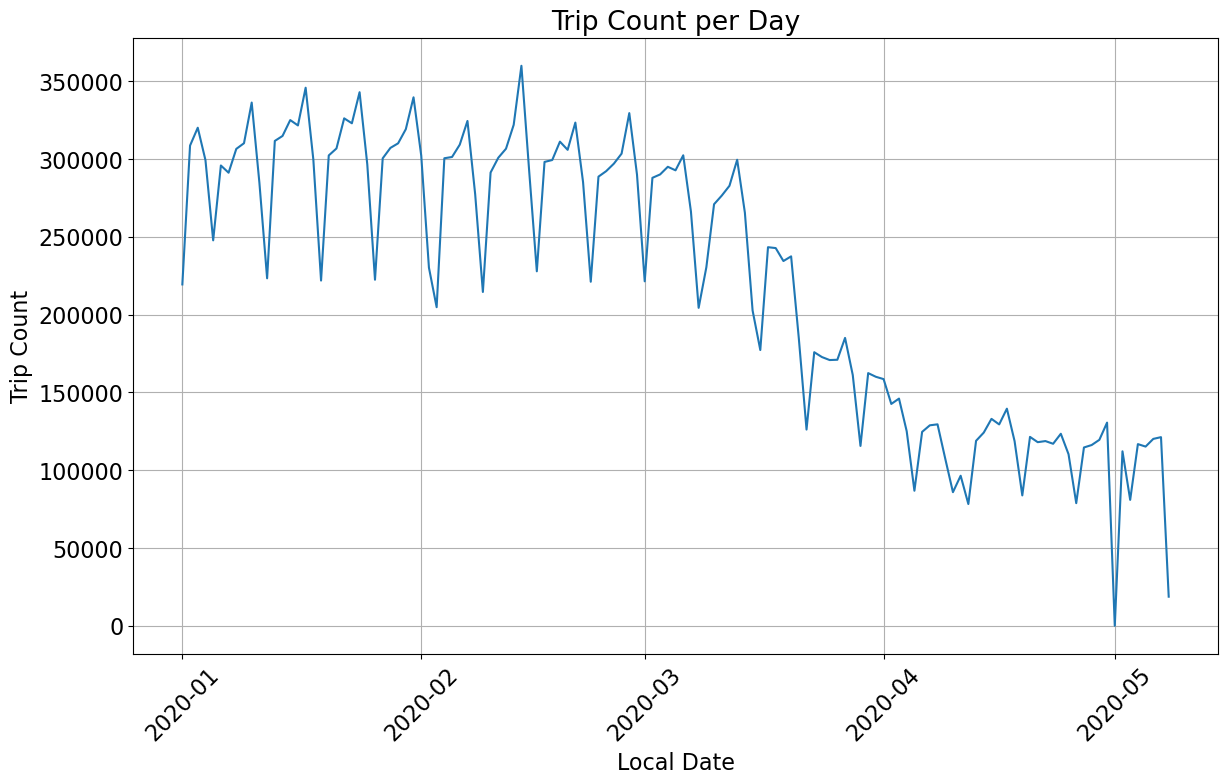

In [39]:
# pip install seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_od is your DataFrame
# Convert 'local_date' to datetime format
df_od['local_date'] = pd.to_datetime(df_od['local_date'], format='%Y%m%d')

# Group by 'local_date' and sum the 'trip_count'
df_daily = df_od.groupby('local_date')['trip_count'].sum().reset_index()

# Initialize the plot
plt.figure(figsize=(14, 8))
plt.rcParams.update({'font.size': 16})  # Increase the default font size

# Plotting with seaborn
sns.lineplot(data=df_daily, x='local_date', y='trip_count')

# Customize the x-axis to show every month
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

# Adding labels and title
plt.xlabel('Local Date')
plt.ylabel('Trip Count')
plt.title('Trip Count per Day')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()


# Check and Processing

In [2]:
folder_path = '/home/jovyan/Data/2020OD/del_3h/IN'

file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
df_list = []

# Loop through the list of files and read each file into a DataFrame
for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path) 
    df_list.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(df_list, ignore_index=True)
combined_df

,local_date,start_geohash5,end_geohash5,grt,trip_count,m_duration_min,mdn_duration_min,sd_duration_min,m_length_m,mdn_length_m,sd_length_m,m_points_no,mdn_points_no,sd_points_no
0,2020-01-04,tue00,tu7pb,0,1,361.766667,361.766667,NaN,5780.274614,5780.274614,NaN,11.000000,11,NaN
1,2020-01-04,tdr4j,tdr4j,7,17,25.486275,15.066667,25.964960,1279.945287,255.914938,1957.646963,3.411765,3,1.325652
2,2020-01-04,tsj8z,tsjcn,3,1,173.633333,173.633333,NaN,38406.182595,38406.182595,NaN,16.000000,16,NaN
3,2020-01-04,texvu,texx1,3,1,303.333333,303.333333,NaN,57100.999568,57100.999568,NaN,4.000000,4,NaN
4,2020-01-04,tehym,tehym,5,6,34.619444,25.000000,34.140389,368.531001,264.373323,374.671738,3.833333,4,2.228602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15963469,2020-08-11,tun8p,tgyxz,3,1,49.366667,49.366667,NaN,2021.527059,2021.527059,NaN,3.000000,3,NaN
15963470,2020-08-11,tuemk,tuemk,3,1,30.133333,30.133333,NaN,346.506355,346.506355,NaN,6.000000,6,NaN
15963471,2020-08-11,tuem7,tuems,7,1,18.566667,18.566667,NaN,4312.436311,4312.436311,NaN,2.000000,2,NaN
15963472,2020-08-11,tf34f,tf351,2,1,102.250000,102.250000,NaN,5118.823858,5118.823858,NaN,3.000000,3,NaN


In [3]:
combined_df['local_date'] = pd.to_datetime(combined_df['local_date']).dt.strftime('%Y%m%d')
# combined_df['trip_count'].sum()
combined_df

,local_date,start_geohash5,end_geohash5,grt,trip_count,m_duration_min,mdn_duration_min,sd_duration_min,m_length_m,mdn_length_m,sd_length_m,m_points_no,mdn_points_no,sd_points_no
0,20200104,tue00,tu7pb,0,1,361.766667,361.766667,NaN,5780.274614,5780.274614,NaN,11.000000,11,NaN
1,20200104,tdr4j,tdr4j,7,17,25.486275,15.066667,25.964960,1279.945287,255.914938,1957.646963,3.411765,3,1.325652
2,20200104,tsj8z,tsjcn,3,1,173.633333,173.633333,NaN,38406.182595,38406.182595,NaN,16.000000,16,NaN
3,20200104,texvu,texx1,3,1,303.333333,303.333333,NaN,57100.999568,57100.999568,NaN,4.000000,4,NaN
4,20200104,tehym,tehym,5,6,34.619444,25.000000,34.140389,368.531001,264.373323,374.671738,3.833333,4,2.228602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15963469,20200811,tun8p,tgyxz,3,1,49.366667,49.366667,NaN,2021.527059,2021.527059,NaN,3.000000,3,NaN
15963470,20200811,tuemk,tuemk,3,1,30.133333,30.133333,NaN,346.506355,346.506355,NaN,6.000000,6,NaN
15963471,20200811,tuem7,tuems,7,1,18.566667,18.566667,NaN,4312.436311,4312.436311,NaN,2.000000,2,NaN
15963472,20200811,tf34f,tf351,2,1,102.250000,102.250000,NaN,5118.823858,5118.823858,NaN,3.000000,3,NaN


In [3]:
time_intervals = {
    0: "00:00:00 - 03:00:00", 1: "03:00:00 - 06:00:00",
    2: "06:00:00 - 09:00:00", 3: "09:00:00 - 12:00:00",
    4: "12:00:00 - 15:00:00", 5: "15:00:00 - 18:00:00",
    6: "18:00:00 - 21:00:00", 7: "21:00:00 - 24:00:00"}
combined_df['local_time'] = combined_df.apply(lambda row: f"{row['local_date']} {time_intervals[row['grt']]}", axis=1).astype(str)
combined_df

,local_date,start_geohash5,end_geohash5,grt,trip_count,m_duration_min,mdn_duration_min,sd_duration_min,m_length_m,mdn_length_m,sd_length_m,m_points_no,mdn_points_no,sd_points_no,local_time
0,20200104,tue00,tu7pb,0,1,361.766667,361.766667,NaN,5780.274614,5780.274614,NaN,11.000000,11,NaN,20200104 00:00:00 - 03:00:00
1,20200104,tdr4j,tdr4j,7,17,25.486275,15.066667,25.964960,1279.945287,255.914938,1957.646963,3.411765,3,1.325652,20200104 21:00:00 - 24:00:00
2,20200104,tsj8z,tsjcn,3,1,173.633333,173.633333,NaN,38406.182595,38406.182595,NaN,16.000000,16,NaN,20200104 09:00:00 - 12:00:00
3,20200104,texvu,texx1,3,1,303.333333,303.333333,NaN,57100.999568,57100.999568,NaN,4.000000,4,NaN,20200104 09:00:00 - 12:00:00
4,20200104,tehym,tehym,5,6,34.619444,25.000000,34.140389,368.531001,264.373323,374.671738,3.833333,4,2.228602,20200104 15:00:00 - 18:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15963469,20200811,tun8p,tgyxz,3,1,49.366667,49.366667,NaN,2021.527059,2021.527059,NaN,3.000000,3,NaN,20200811 09:00:00 - 12:00:00
15963470,20200811,tuemk,tuemk,3,1,30.133333,30.133333,NaN,346.506355,346.506355,NaN,6.000000,6,NaN,20200811 09:00:00 - 12:00:00
15963471,20200811,tuem7,tuems,7,1,18.566667,18.566667,NaN,4312.436311,4312.436311,NaN,2.000000,2,NaN,20200811 21:00:00 - 24:00:00
15963472,20200811,tf34f,tf351,2,1,102.250000,102.250000,NaN,5118.823858,5118.823858,NaN,3.000000,3,NaN,20200811 06:00:00 - 09:00:00


## Check duplicates

In [5]:
# combined_df['start_geohash3'] = combined_df['start_geohash3'].astype(str)
# combined_df['end_geohash3'] = combined_df['end_geohash3'].astype(str)

combined_df['start_geohash5'] = combined_df['start_geohash5'].astype(str)
combined_df['end_geohash5'] = combined_df['end_geohash5'].astype(str)

combined_df['local_date'] = combined_df['local_date'].astype(int)
combined_df['trip_count'] = combined_df['trip_count'].astype(int)
combined_df['m_duration_min'] = combined_df['m_duration_min'].astype(float)
combined_df['mdn_duration_min'] = combined_df['mdn_duration_min'].astype(float)
combined_df['sd_duration_min'] = combined_df['sd_duration_min'].astype(float)
combined_df['m_length_m'] = combined_df['m_length_m'].astype(float)
combined_df['mdn_length_m'] = combined_df['mdn_length_m'].astype(float)
combined_df['sd_length_m'] = combined_df['sd_length_m'].astype(float)
combined_df['m_points_no'] = combined_df['m_points_no'].astype(float)
combined_df['mdn_points_no'] = combined_df['mdn_points_no'].astype(float)
combined_df['sd_points_no'] = combined_df['sd_points_no'].astype(float)
combined_df['local_time'] = combined_df['local_time'].astype(str)

# Round float columns to 6 decimal places
float_columns = ['m_duration_min', 'mdn_duration_min', 'sd_duration_min',
                 'm_length_m', 'mdn_length_m', 'sd_length_m',
                 'm_points_no', 'mdn_points_no', 'sd_points_no']

combined_df[float_columns] = combined_df[float_columns].round(6)
combined_df = combined_df.drop_duplicates()
combined_df = combined_df.sort_values('local_time').reset_index(drop = True)
combined_df

,local_date,start_geohash5,end_geohash5,grt,trip_count,m_duration_min,mdn_duration_min,sd_duration_min,m_length_m,mdn_length_m,sd_length_m,m_points_no,mdn_points_no,sd_points_no,local_time
0,20200101,te7u7,te7gc,0,1,81.000000,81.000000,NaN,14615.473137,14615.473137,NaN,2.000000,2.0,NaN,20200101 00:00:00 - 03:00:00
1,20200101,tstnc,tstnc,0,1,500.700000,500.700000,NaN,412.185015,412.185015,NaN,4.000000,4.0,NaN,20200101 00:00:00 - 03:00:00
2,20200101,tdn3k,tdn3k,0,1,715.216667,715.216667,NaN,1947.129024,1947.129024,NaN,6.000000,6.0,NaN,20200101 00:00:00 - 03:00:00
3,20200101,tdu2r,tdu2r,0,3,459.750000,43.416667,746.599583,8140.963015,4384.213219,6521.387059,3.666667,2.0,2.886751,20200101 00:00:00 - 03:00:00
4,20200101,tuk5z,tujyg,0,1,379.916667,379.916667,NaN,256013.862234,256013.862234,NaN,24.000000,24.0,NaN,20200101 00:00:00 - 03:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15963468,20201231,tfcmp,tfcmp,7,1,12.283333,12.283333,NaN,1028.527653,1028.527653,NaN,3.000000,3.0,NaN,20201231 21:00:00 - 24:00:00
15963469,20201231,tekj0,tekj0,7,1,118.183333,118.183333,NaN,474.715284,474.715284,NaN,5.000000,5.0,NaN,20201231 21:00:00 - 24:00:00
15963470,20201231,tdp22,tdp23,7,1,25.633333,25.633333,NaN,107.666846,107.666846,NaN,2.000000,2.0,NaN,20201231 21:00:00 - 24:00:00
15963471,20201231,tepfb,tepfc,7,1,14.733333,14.733333,NaN,1761.234440,1761.234440,NaN,4.000000,4.0,NaN,20201231 21:00:00 - 24:00:00


## Check missing dates

In [9]:
unique_values_count = combined_df["local_date"].unique()
all_dates = pd.date_range(start='2020-01-01', end='2020-12-31').strftime('%Y%m%d').astype(int)
all_dates = np.array(all_dates)
missing_dates = np.setdiff1d(all_dates, unique_values_count)

missing_dates

array([20200501])

## Check for hours per day (for 3h)

In [11]:
# Convert local_date to datetime objects
combined_df['local_date'] = pd.to_datetime(combined_df['local_date'], format='%Y%m%d')

# Function to parse the local_time column and extract the start hour
def parse_start_hour(time_str):
    try:
        start_time_str, _ = time_str.split(' - ')
        start_time = datetime.strptime(start_time_str, '%Y%m%d %H:%M:%S')
        return start_time.hour
    except ValueError:
        return None

combined_df['start_hour'] = combined_df['local_time'].map(parse_start_hour)

# Required hours to check
required_hours = set([0, 3, 6, 9, 12, 15, 18, 21])

# Group by local_date and check missing hours
missing_hours = {}

for date, group in combined_df.groupby('local_date'):
    present_hours = set(group['start_hour'])
    missing = required_hours - present_hours
    if missing:
        missing_hours[date] = sorted(list(missing))

# Convert missing hours dictionary to DataFrame for better readability
missing_hours_df = pd.DataFrame(list(missing_hours.items()), columns=['Date', 'Missing Hours'])

# Display the missing hours
print("Missing hours for each date:")
print(missing_hours_df)

Missing hours for each date:
Empty DataFrame
Columns: [Date, Missing Hours]
Index: []


## Check with figure

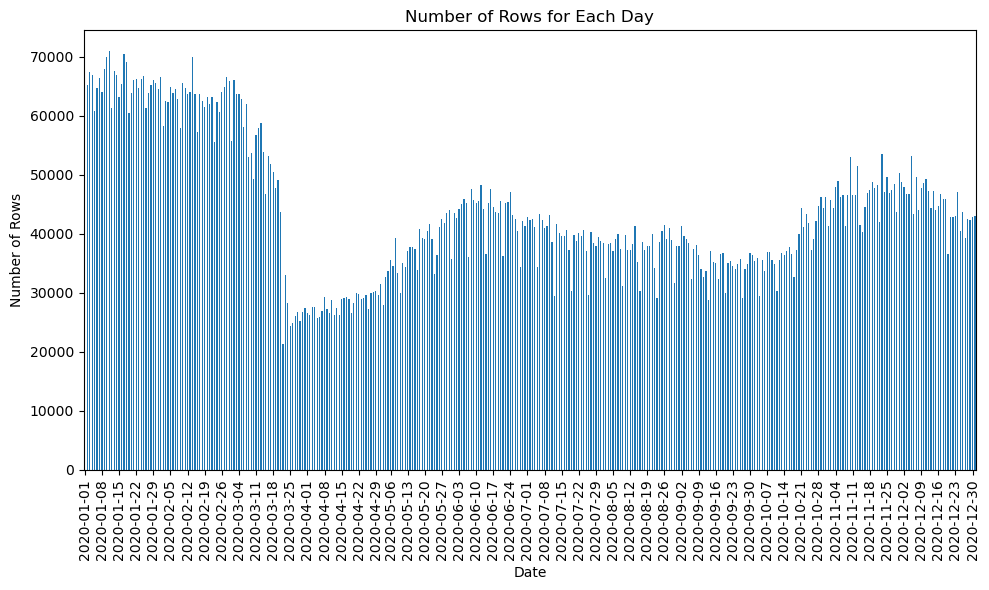

In [15]:
daily_counts = combined_df['local_date'].value_counts().sort_index()

# Generate custom xticks starting from the first date and then incrementing by 7 days
start_date = daily_counts.index.min()
end_date = daily_counts.index.max()
custom_xticks = pd.date_range(start=start_date, end=end_date, freq='7D')

# Plot the results
plt.figure(figsize=(10, 6))
daily_counts.plot(kind='bar')
plt.title('Number of Rows for Each Day')
plt.xlabel('Date')
plt.ylabel('Number of Rows')
plt.xticks(ticks=range(len(daily_counts)), labels=daily_counts.index.strftime('%Y-%m-%d'), rotation=90)
plt.gca().set_xticks([i for i, date in enumerate(daily_counts.index) if date in custom_xticks])
plt.tight_layout()
plt.show()

## Export

In [16]:
combined_df

,local_date,start_geohash5,end_geohash5,grt,trip_count,m_duration_min,mdn_duration_min,sd_duration_min,m_length_m,mdn_length_m,sd_length_m,m_points_no,mdn_points_no,sd_points_no,local_time,start_hour
0,2020-01-01,te7u7,te7gc,0,1,81.000000,81.000000,NaN,14615.473137,14615.473137,NaN,2.000000,2.0,NaN,20200101 00:00:00 - 03:00:00,0
1,2020-01-01,tstnc,tstnc,0,1,500.700000,500.700000,NaN,412.185015,412.185015,NaN,4.000000,4.0,NaN,20200101 00:00:00 - 03:00:00,0
2,2020-01-01,tdn3k,tdn3k,0,1,715.216667,715.216667,NaN,1947.129024,1947.129024,NaN,6.000000,6.0,NaN,20200101 00:00:00 - 03:00:00,0
3,2020-01-01,tdu2r,tdu2r,0,3,459.750000,43.416667,746.599583,8140.963015,4384.213219,6521.387059,3.666667,2.0,2.886751,20200101 00:00:00 - 03:00:00,0
4,2020-01-01,tuk5z,tujyg,0,1,379.916667,379.916667,NaN,256013.862234,256013.862234,NaN,24.000000,24.0,NaN,20200101 00:00:00 - 03:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15963468,2020-12-31,tfcmp,tfcmp,7,1,12.283333,12.283333,NaN,1028.527653,1028.527653,NaN,3.000000,3.0,NaN,20201231 21:00:00 - 24:00:00,21
15963469,2020-12-31,tekj0,tekj0,7,1,118.183333,118.183333,NaN,474.715284,474.715284,NaN,5.000000,5.0,NaN,20201231 21:00:00 - 24:00:00,21
15963470,2020-12-31,tdp22,tdp23,7,1,25.633333,25.633333,NaN,107.666846,107.666846,NaN,2.000000,2.0,NaN,20201231 21:00:00 - 24:00:00,21
15963471,2020-12-31,tepfb,tepfc,7,1,14.733333,14.733333,NaN,1761.234440,1761.234440,NaN,4.000000,4.0,NaN,20201231 21:00:00 - 24:00:00,21


In [ ]:
combined_df = combined_df.drop(['start_hour'], axis=1)
# combined_df = combined_df.drop(['grt'], axis=1)
combined_df['local_date'] = combined_df['local_date'].dt.strftime('%Y%m%d').astype(int)
combined_df = combined_df.sort_values('local_time').reset_index(drop=True)
combined_df

In [5]:
combined_df.to_csv('/home/jovyan/Data/2020OD/del_3h/IN/combined/od_3h_gh5_in_2020_all.csv', index=False)

In [6]:
filterdf = combined_df[combined_df['trip_count'] > 9]
filterdf

,local_date,start_geohash5,end_geohash5,trip_count,m_duration_min,mdn_duration_min,sd_duration_min,m_length_m,mdn_length_m,sd_length_m,m_points_no,mdn_points_no,sd_points_no,local_time
325,20200101,tegbd,tegbd,11,62.563636,14.566667,134.288404,370.493331,138.998524,464.658791,3.181818,2.0,3.060006,20200101 00:00:00 - 03:00:00
329,20200101,tg5hz,tg5hz,14,120.885714,16.500000,269.189768,3017.278723,945.835966,5126.103404,3.214286,3.0,1.528125,20200101 00:00:00 - 03:00:00
340,20200101,tdu2p,tdu2p,14,13.460714,10.300000,11.341501,1149.994308,827.788194,1050.659004,2.285714,2.0,0.825420,20200101 00:00:00 - 03:00:00
382,20200101,tepg1,tepg1,16,110.291667,27.516667,210.691707,2685.697122,740.930583,4703.665961,4.125000,2.0,3.844910,20200101 00:00:00 - 03:00:00
448,20200101,tek99,tek99,20,140.997500,31.150000,287.819520,1336.098478,293.361886,3538.862702,12.350000,2.0,42.086721,20200101 00:00:00 - 03:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15963341,20201231,tepg4,tepg4,10,29.198333,25.533333,27.604710,751.912757,412.653903,708.572948,5.300000,4.0,3.713339,20201231 21:00:00 - 24:00:00
15963348,20201231,te7u9,te7u9,12,16.815278,16.633333,7.739442,2669.107759,1111.817518,6200.857378,4.166667,4.0,1.527525,20201231 21:00:00 - 24:00:00
15963381,20201231,te7y3,te7y3,13,35.408974,24.950000,30.146257,1143.708096,456.521665,1624.234092,4.615385,3.0,3.042435,20201231 21:00:00 - 24:00:00
15963386,20201231,tepg1,tepg1,10,42.625000,53.466667,24.071347,1117.338571,1087.797373,985.311620,4.400000,4.0,1.577621,20201231 21:00:00 - 24:00:00


In [7]:
filterdf.to_csv('/home/jovyan/Data/2020OD/del_3h/IN/combined/od_3h_gh5_in_2020.csv', index=False)

In [2]:
combined_f = '/home/jovyan/Data/2020OD/del_3h/IN/combined/od_3h_gh5_in_2020_all.csv'
combined_df = pd.read_csv(combined_f)